In [1]:
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import warnings
from utils import *
sns.set_theme(style="darkgrid", palette="pastel")
sns.color_palette("Set2")
warnings.filterwarnings("ignore")

df = pd.read_csv("data.csv") 
df.head(10)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
5,21651,city_176,0.764,NaN,Has relevent experience,Part time course,Graduate,STEM,11,NaN,NaN,1,24,1.0
6,28806,city_160,0.920,Male,Has relevent experience,no_enrollment,High School,NaN,5,50-99,Funded Startup,1,24,0.0
7,402,city_46,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4,18,1.0
8,27107,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,7,50-99,Pvt Ltd,1,46,1.0
9,699,city_103,0.920,NaN,Has relevent experience,no_enrollment,Graduate,STEM,17,10000+,Pvt Ltd,>4,123,0.0


Columns like *experinece*, *last_new_job* and *company_size* might require transformations like deleting the '>' symbol form the *last_new_job* column and others.

In [2]:
df.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [4]:
df.nunique()

enrollee_id               19158
city                        123
city_development_index       93
gender                        3
relevent_experience           2
enrolled_university           3
education_level               5
major_discipline              6
experience                   22
company_size                  8
company_type                  6
last_new_job                  6
training_hours              241
target                        2
dtype: int64

# EDA

## Data Distribution

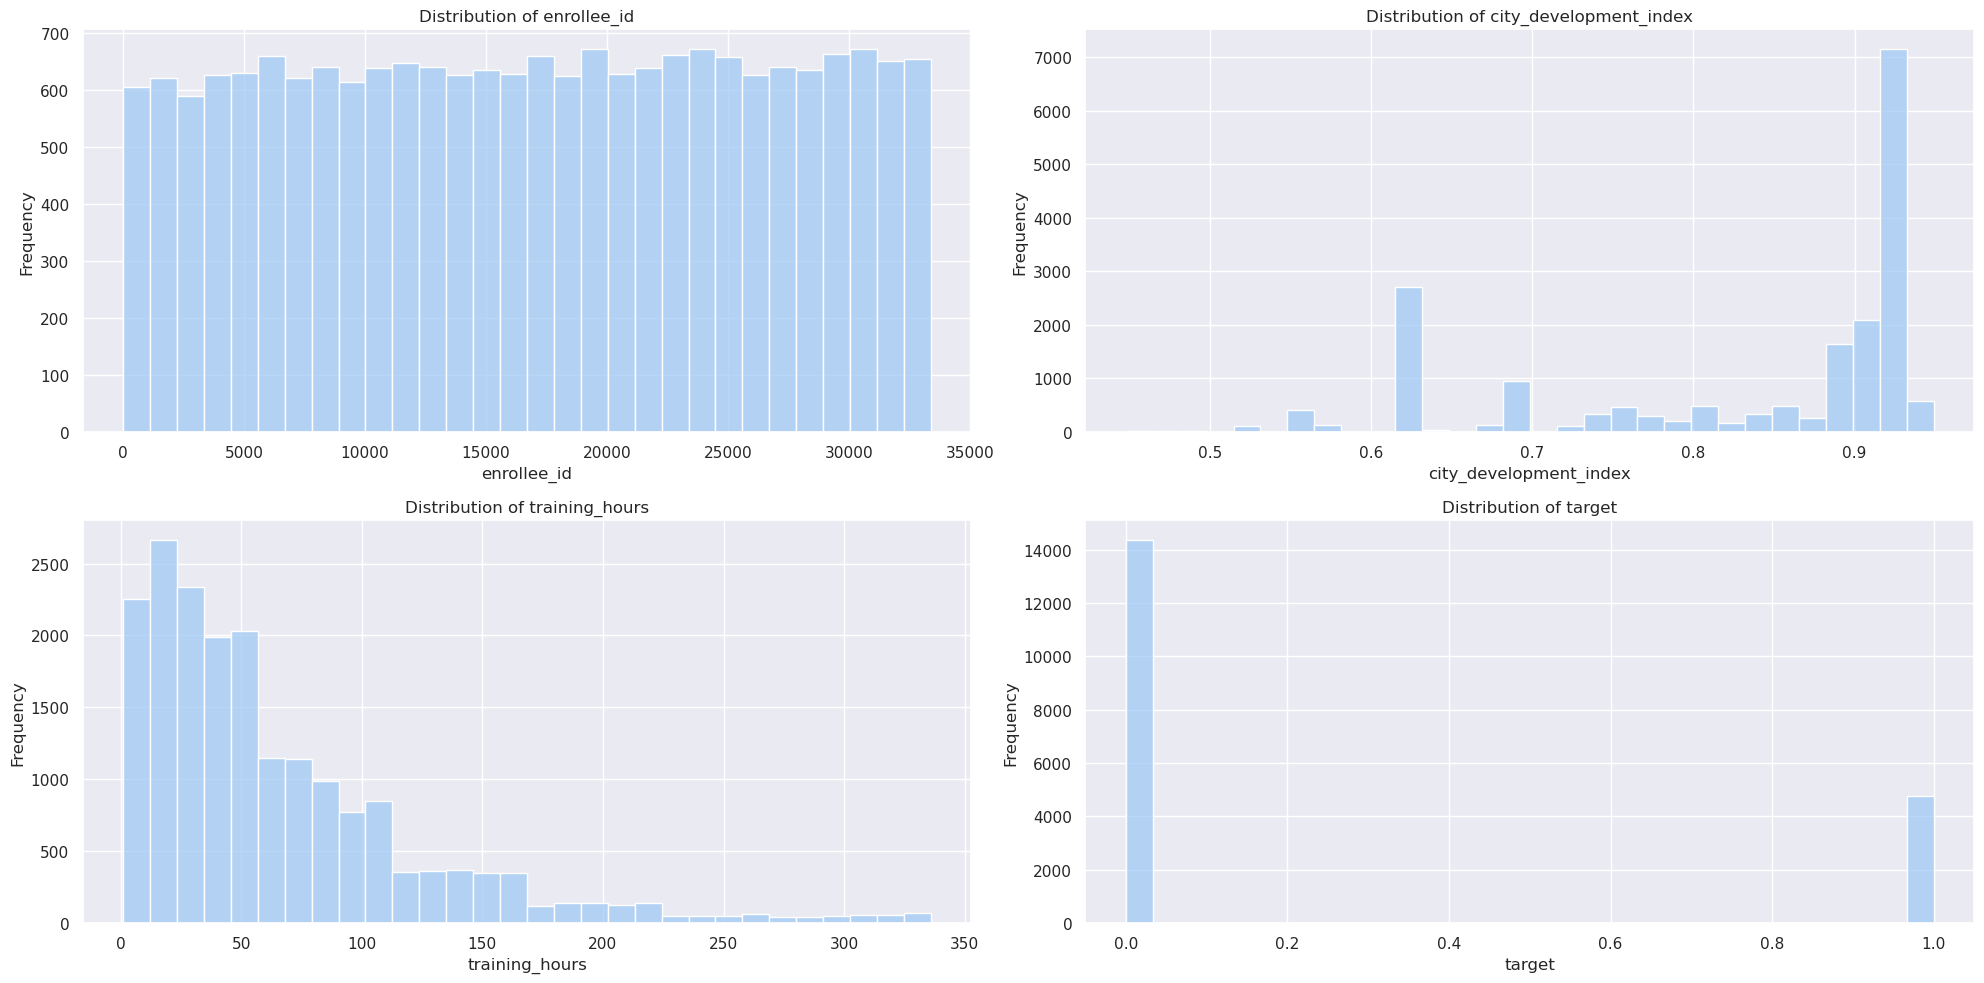

In [5]:
plot_numerical_columns_distribution(df, 2, 2)

The *training_hours* and *city_development_index* are skewed, thus we might need some data normalization in the future. 

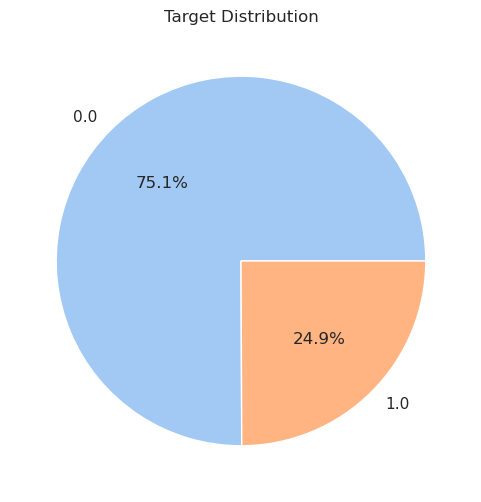

In [6]:
data=df['target'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(data ,labels=data.index, autopct='%1.1f%%')
plt.title('Target Distribution')
plt.show()

The *target* column distribution is not as good as expected, thus in the future we will use techniques like undersampling or oversampling depending on the situation.

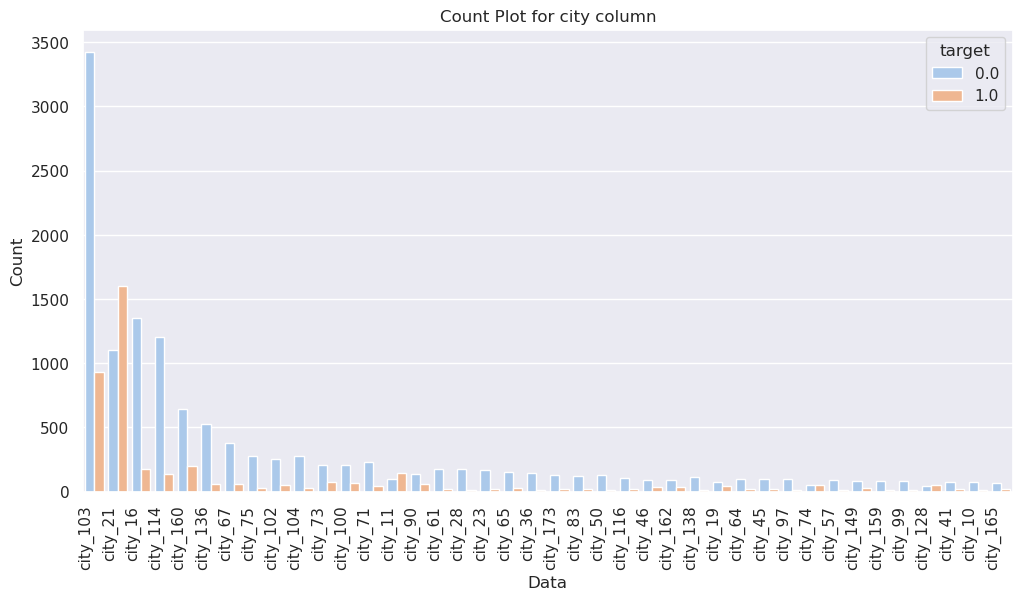

In [7]:
target_countplot(df,'city','target')

Speaking about cities and city index, we see that the most people that are applying to this job are coming from city_103 and city_21. These cities have a high development index, thus their citizens might have more resources and priviledges. This column could be deleted, because it is in high correlation with *city_development_index*, thus there is no need for it.

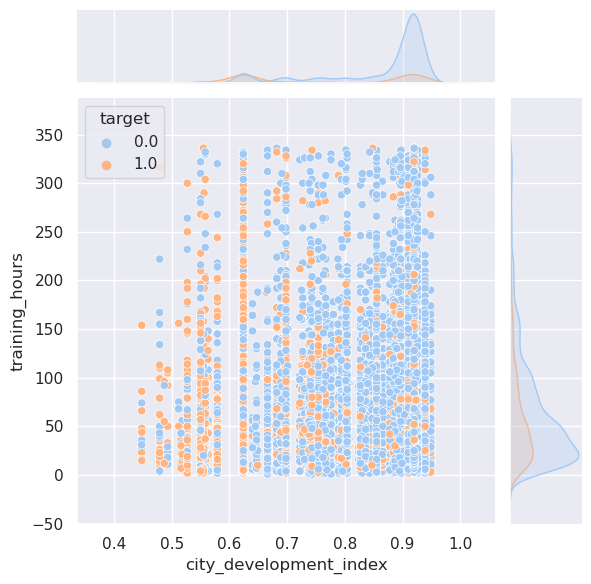

In [8]:
sns.jointplot(x='city_development_index',y='training_hours',data=df,hue='target');

People that are coming from cities with high development index, are inclined to have a higher number of training hours. Also, it can be seen that even if number of training hours is small, and people are coming from less wealthy cities, they have a higher chance to get the job.

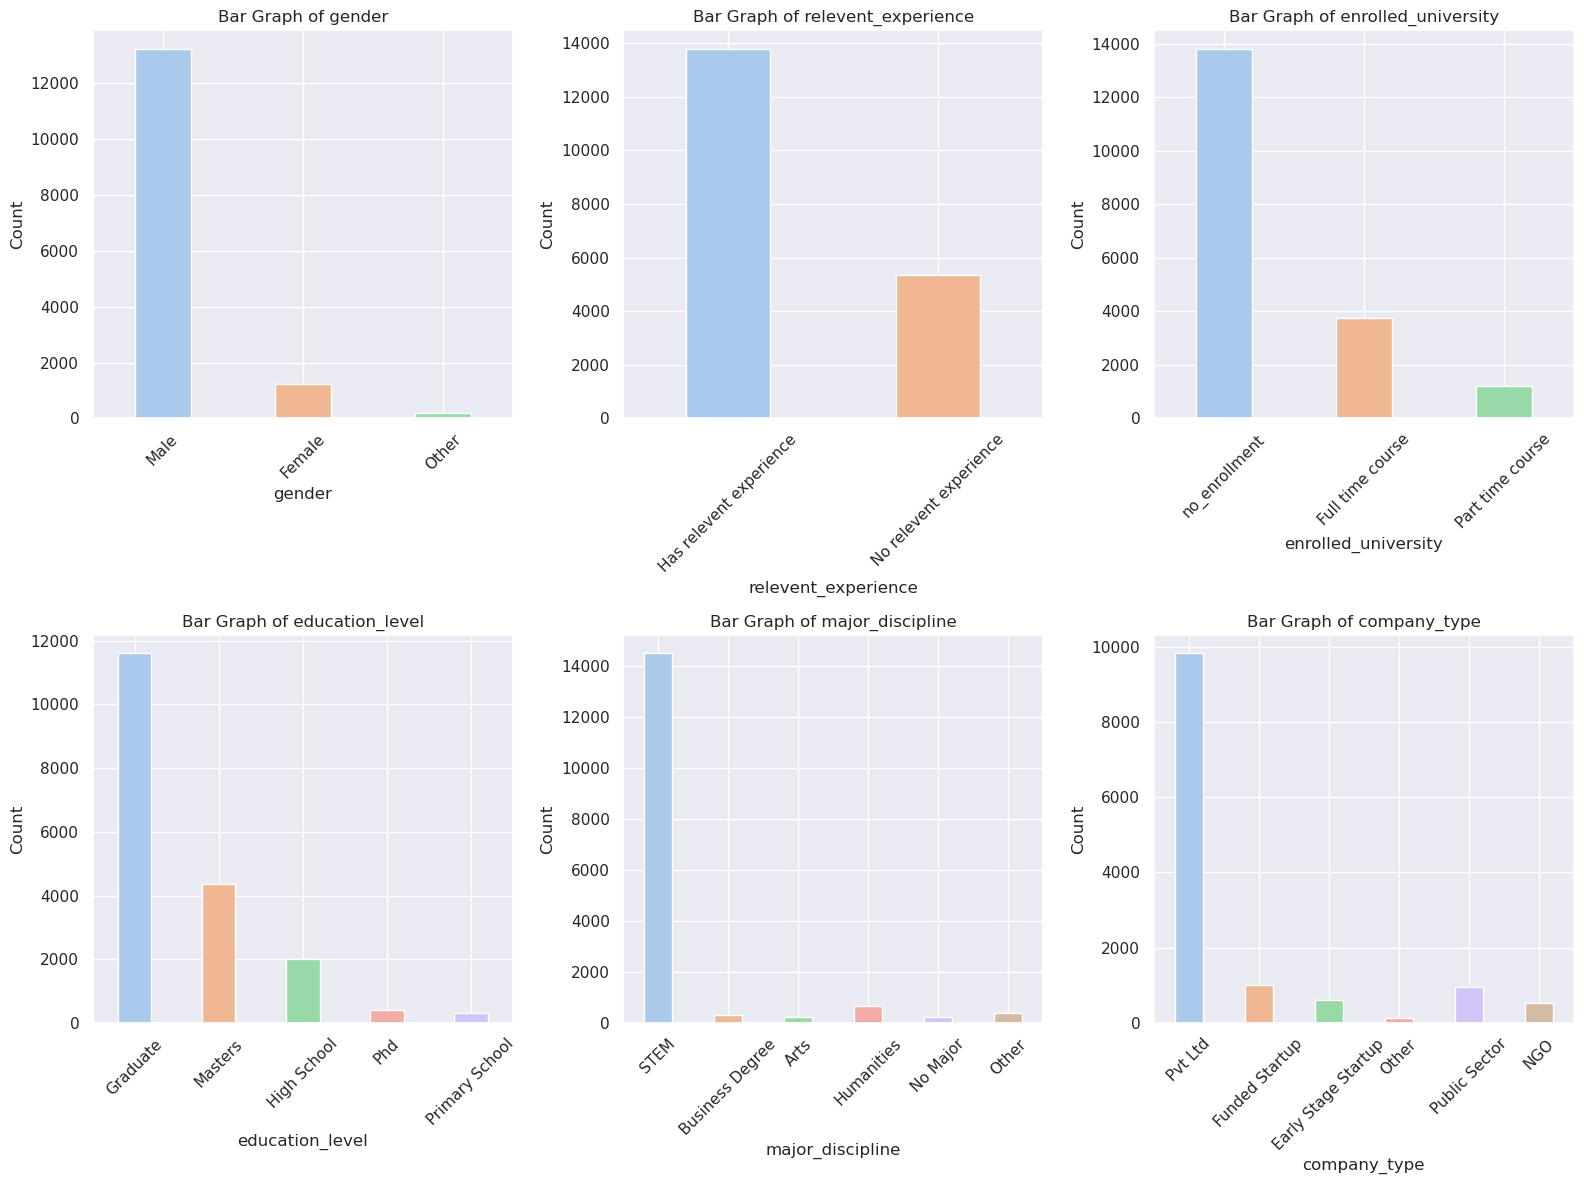

In [9]:
plot_categorical_columns(df[['gender',
                             'relevent_experience',
                             'enrolled_university',
                             'education_level',
                             'major_discipline',
                             'company_type']],3,2)

The object type columns have a skewed distribution, however not all columns have equal importance.The *company_type*  is not so important, due to distribution. For the machine, it would seem that *Pvt Ltd* company type is much more important than the other types, however it's not. The *Gender* column is not well distributed due to the lack of data, however it seems accurate if we compare the distribution with real data that's why it is important.

## Outlier Analysis

In [10]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
for k, v in df[numerical_columns].items():
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    irq = q3 - q1
    v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
    perc = np.shape(v_col)[0] * 100.0 / np.shape(df)[0]
    print("Column %s outliers = %.2f%%" % (k, perc))

Column enrollee_id outliers = 0.00%
Column city_development_index outliers = 0.09%
Column training_hours outliers = 5.14%
Column target outliers = 100.00%


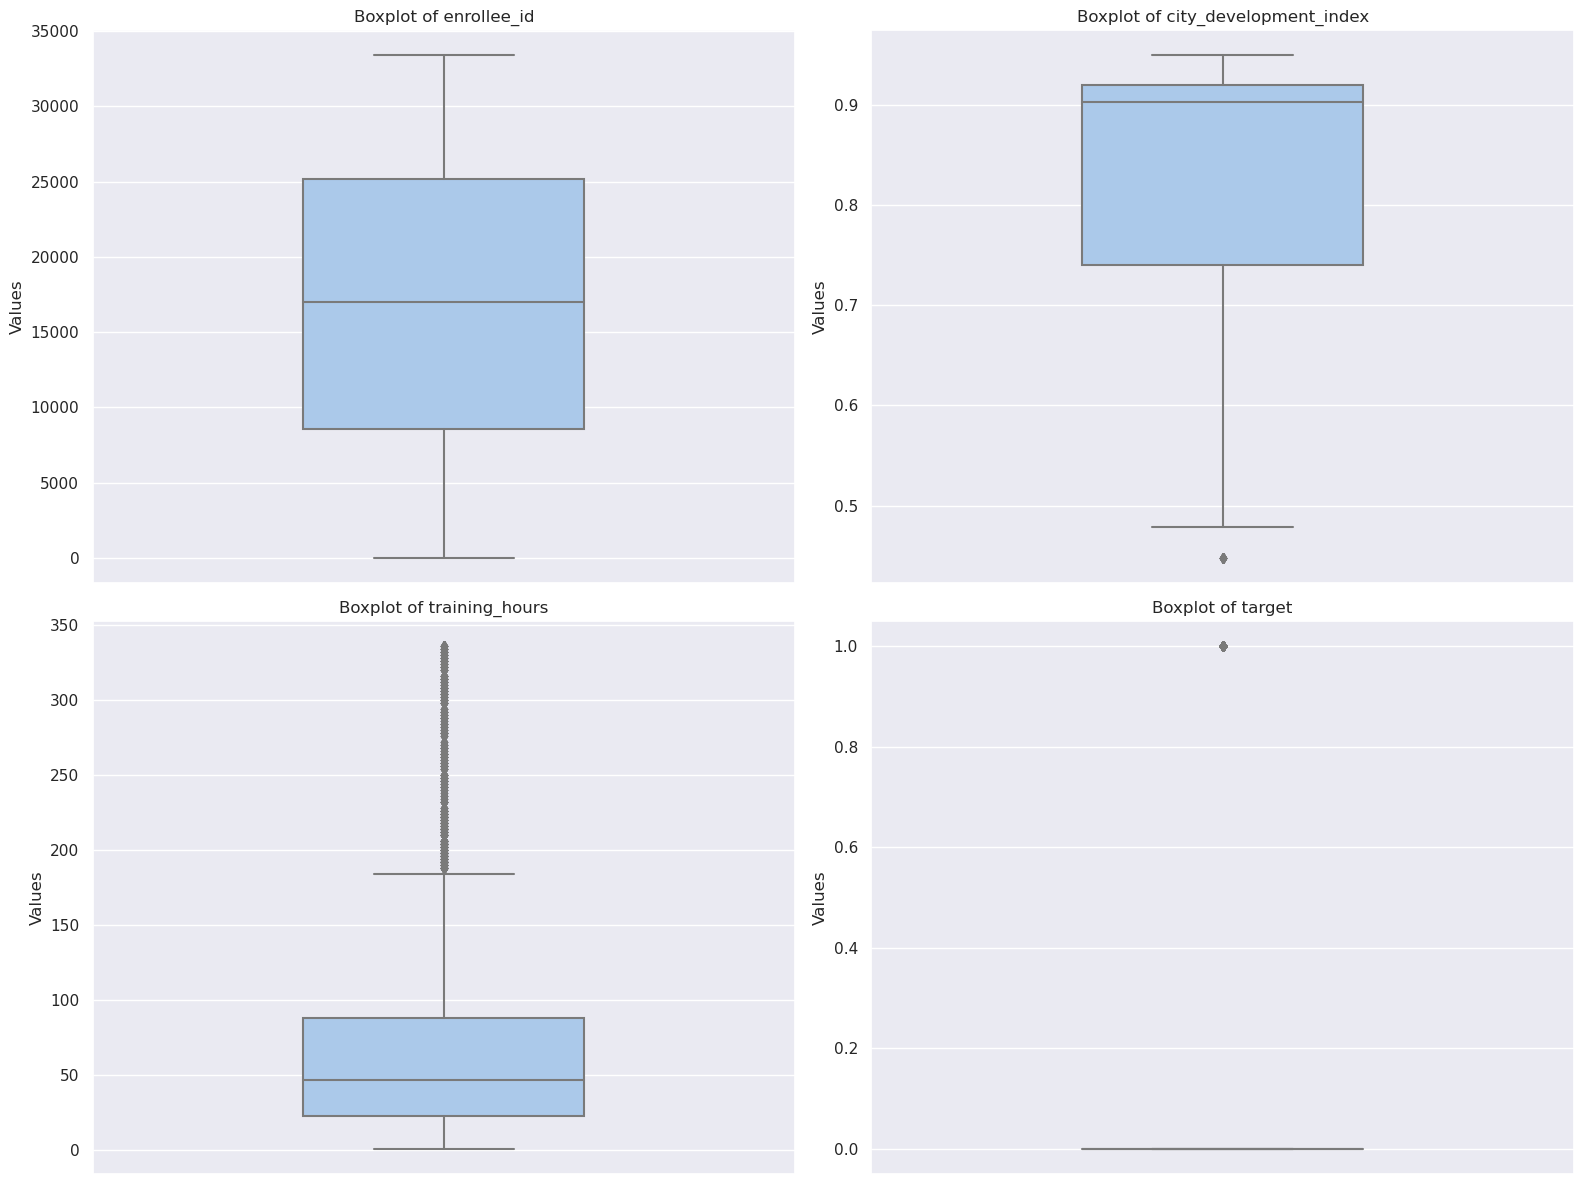

In [11]:
plot_outliers_boxplot(df)

The column that has the most outliers is *training_hours*.

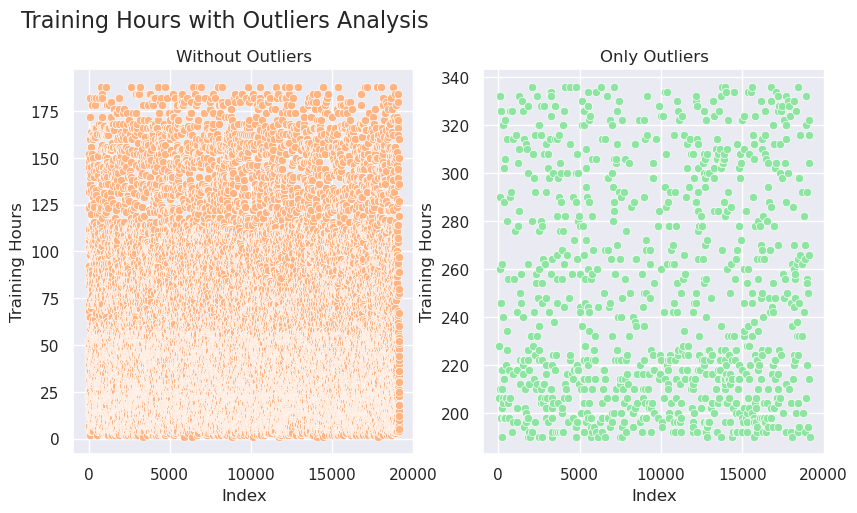

In [12]:
from sklearn.ensemble import IsolationForest
X = df[['training_hours']]
model = IsolationForest(contamination=0.05)  
model.fit(X)
df['is_outlier'] = model.predict(X)
df['is_outlier'] = df['is_outlier'].astype('category')

colors = sns.color_palette("pastel")
plt.subplot(1, 3, 2)
sns.scatterplot(x=df[df['is_outlier'] == 1].index, y=df[df['is_outlier'] == 1]['training_hours'], color=colors[1])
plt.title('Without Outliers')
plt.xlabel('Index')
plt.ylabel('Training Hours')

plt.subplot(1, 3, 3)
sns.scatterplot(x=df[df['is_outlier'] == -1].index, y=df[df['is_outlier'] == -1]['training_hours'], color=colors[2])
plt.title('Only Outliers')
plt.xlabel('Index')
plt.ylabel('Training Hours')

plt.gcf().set_size_inches(15, 5)

plt.suptitle('Training Hours with Outliers Analysis', fontsize=16, y=1)
plt.show()

The outliers for this column seem viable and workable with, for there is no need to process them.

## Missing Values Analysis

<Axes: >

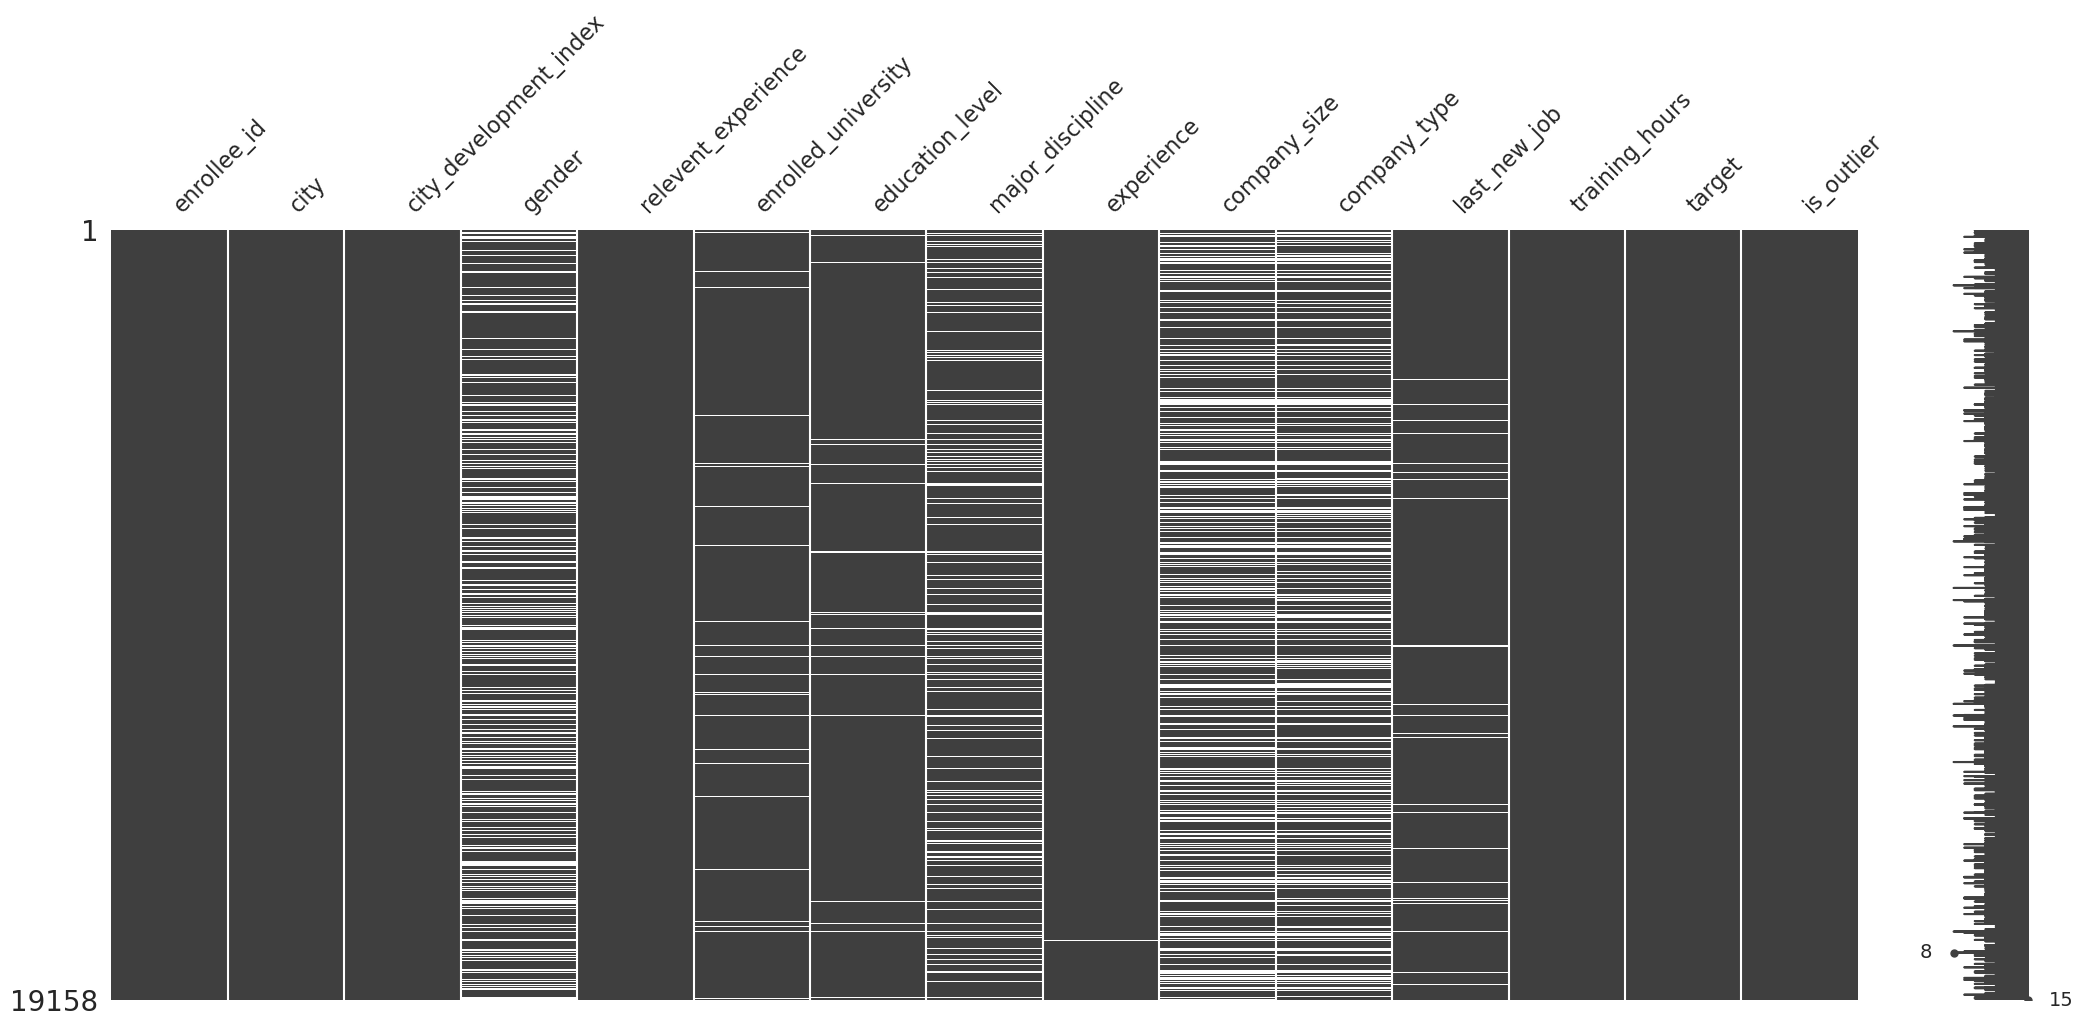

In [13]:
import seaborn as sns
import pandas as pd
import missingno as msno
%matplotlib inline
msno.matrix(df)

<Axes: >

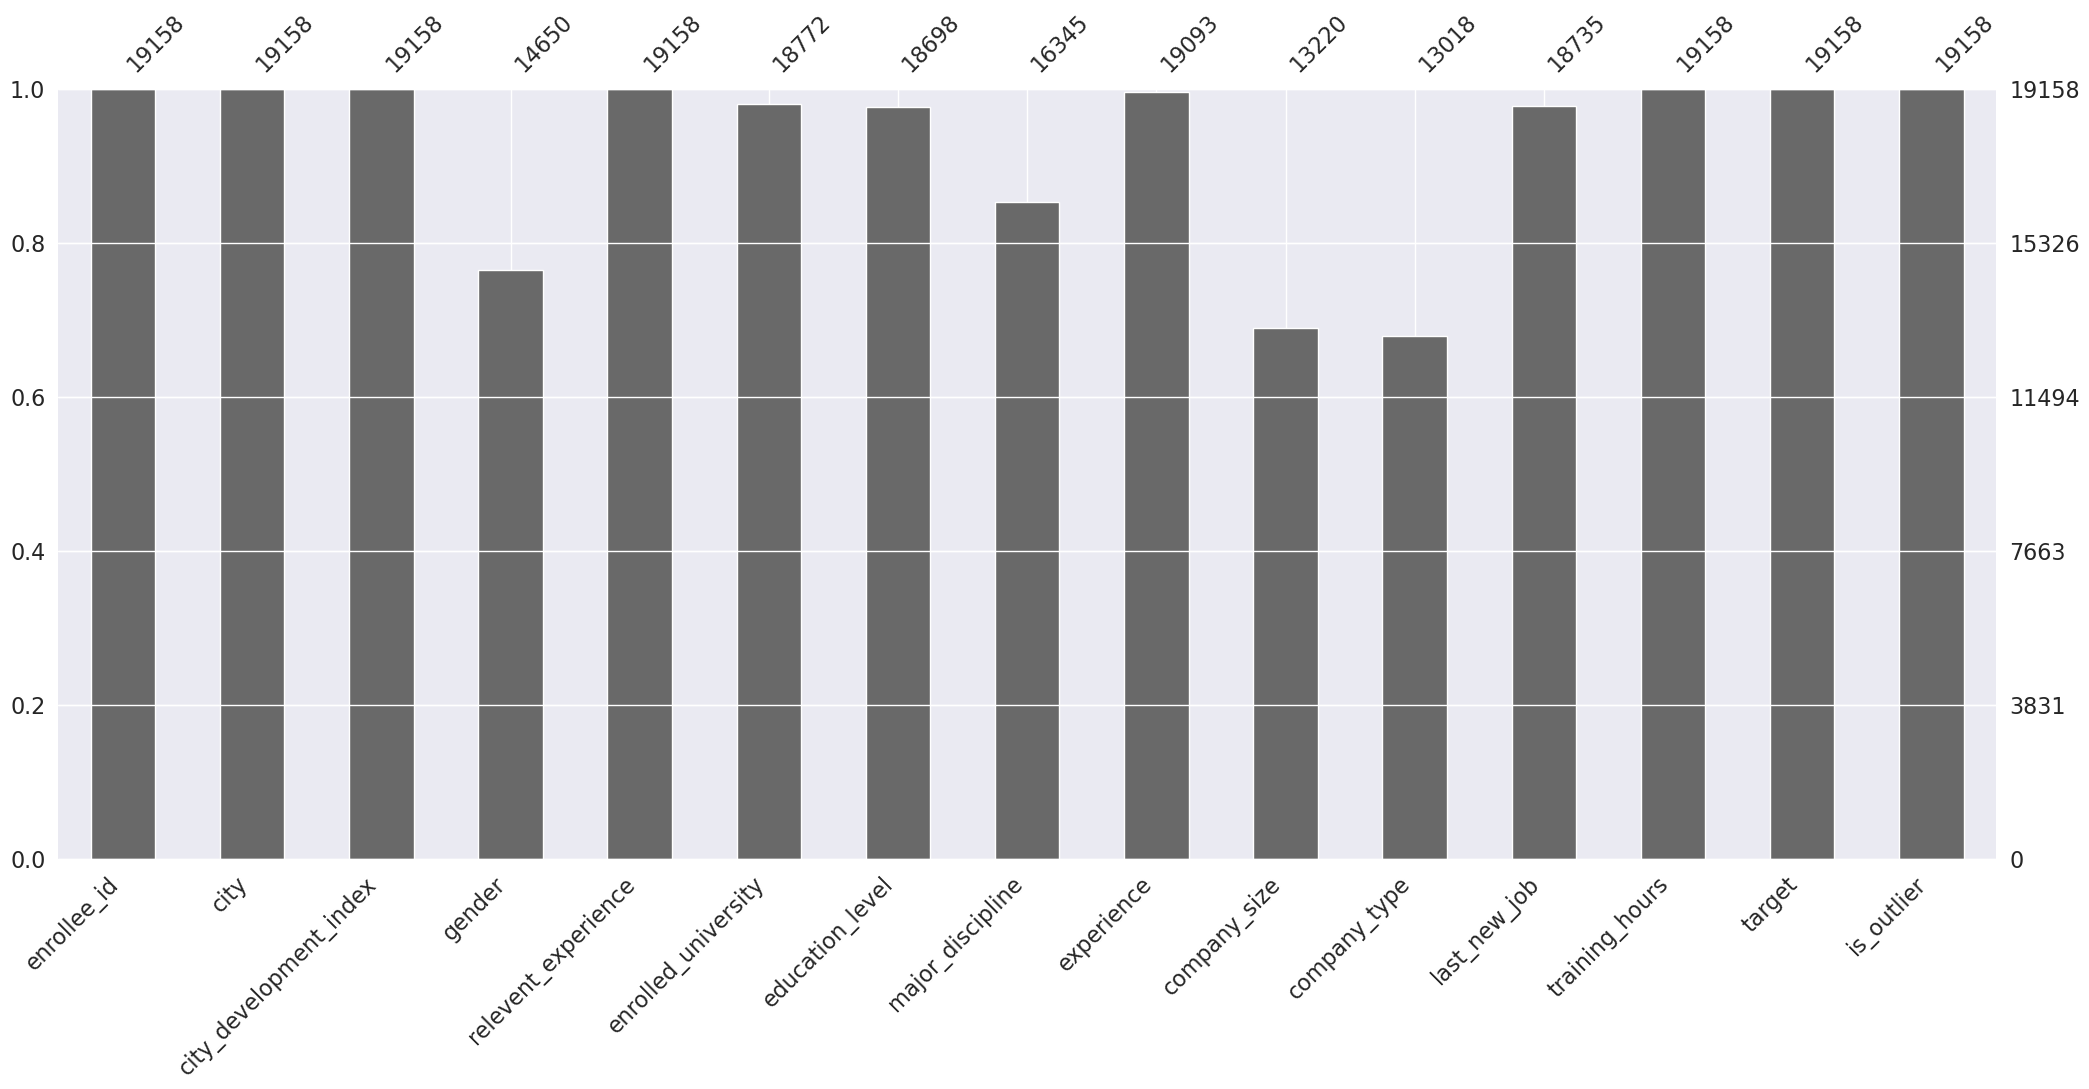

In [14]:
msno.bar(df)

Columns like *gender*, *major_discipline* and *company_type* have the most missing values. It could be risky to deal with them using data imputing, that's why, a good thing would be to see the corralation and do feature selection, and after that if there is not need for them, to delete them.

# Data Preprocessing

In [15]:
df['experience'].unique()

array(['>20', '15', '5', '<1', '11', '13', '7', '17', '2', '16', '1', '4',
       '10', '14', '18', '19', '12', '3', '6', '9', '8', '20', nan],
      dtype=object)

In [16]:
df['last_new_job'].unique()

array(['1', '>4', 'never', '4', '3', '2', nan], dtype=object)

In [17]:
def convert_thresholds(x):
    if x is None:
        return None

    if isinstance(x, int):
        return x

    if isinstance(x, float):
        if math.isnan(x):
            return None
        return int(x)

    if isinstance(x, str):
        if x == 'never':
            x = 0
        elif '>' in x:
            x = int(x.split('>')[-1]) + 1
        elif '<' in x:
            x = int(x.split('<')[-1]) - 0.5
        else:
            x = int(x.strip())

    return x

df['experience'] = df['experience'].map(convert_thresholds)
df['last_new_job'] = df['last_new_job'].map(convert_thresholds)

print(df['experience'].unique())
print(df['last_new_job'].unique())

[21.  15.   5.   0.5 11.  13.   7.  17.   2.  16.   1.   4.  10.  14.
 18.  19.  12.   3.   6.   9.   8.  20.   nan]
[ 1.  5.  0.  4.  3.  2. nan]


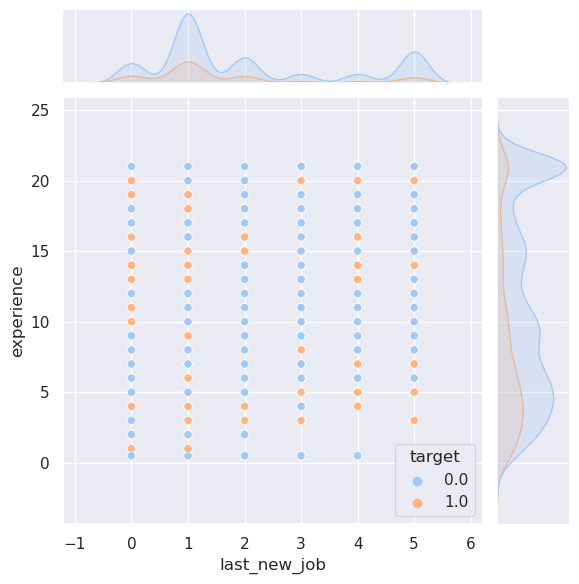

In [18]:
sns.jointplot(x='last_new_job',y='experience',data=df,hue='target');

In [19]:
df['company_size'].unique()

array([nan, '50-99', '<10', '10000+', '5000-9999', '1000-4999', '10/49',
       '100-500', '500-999'], dtype=object)

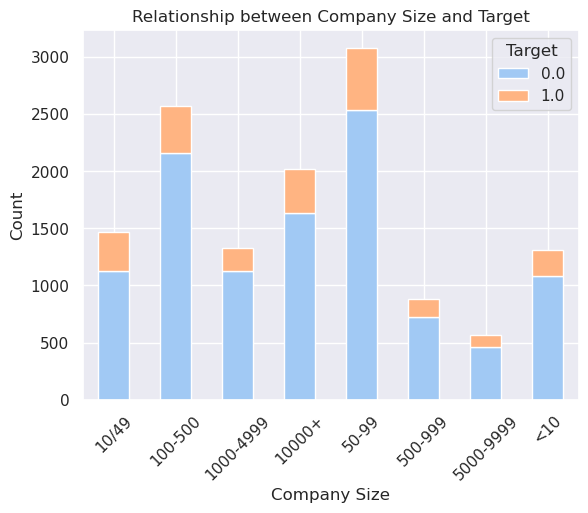

In [20]:
crosstab = pd.crosstab(df['company_size'], df['target'])

crosstab.plot(kind='bar', stacked=True)
plt.xlabel('Company Size')
plt.ylabel('Count')
plt.title('Relationship between Company Size and Target')
plt.legend(title='Target')
plt.xticks(rotation=45)
plt.show()

In [21]:
company_size = {
    '<10'       : 0,
    '10/49'     : 1,
    '50-99'     : 2,
    '100-500'   : 3,
    '500-999'   : 4,
    '1000-4999' : 5,
    '5000-9999' : 6,
    '10000+'    : 7
}

df['company_size'] = df.company_size.map(lambda x: company_size.get(x, None))

In [22]:
df.drop(columns=['enrollee_id', 'city','is_outlier'], inplace=True)
df.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21.0,NaN,NaN,1.0,36,1.0
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,2.0,Pvt Ltd,5.0,47,0.0
2,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5.0,NaN,NaN,0.0,83,0.0
3,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,0.5,NaN,Pvt Ltd,0.0,52,1.0
4,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,21.0,2.0,Funded Startup,4.0,8,0.0


In [23]:
categorical_columns = df.select_dtypes(include=['object']).columns.to_list()
for column in categorical_columns:
    print(f"{column} : {df[column].unique()}\n")

gender : ['Male' nan 'Female' 'Other']

relevent_experience : ['Has relevent experience' 'No relevent experience']

enrolled_university : ['no_enrollment' 'Full time course' nan 'Part time course']

education_level : ['Graduate' 'Masters' 'High School' nan 'Phd' 'Primary School']

major_discipline : ['STEM' 'Business Degree' nan 'Arts' 'Humanities' 'No Major' 'Other']

company_type : [nan 'Pvt Ltd' 'Funded Startup' 'Early Stage Startup' 'Other'
 'Public Sector' 'NGO']



In [24]:
from category_encoders import TargetEncoder
categorical_columns = df.select_dtypes(include=['object']).columns.to_list()

encoder = TargetEncoder(handle_missing = 'return_nan')
df[categorical_columns] = encoder.fit_transform(df[categorical_columns], df['target'])
df.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,0.920,0.227819,0.214690,0.211406,0.27979,0.261593,21.0,NaN,NaN,1.0,36,1.0
1,0.776,0.227819,0.338427,0.211406,0.27979,0.261593,15.0,2.0,0.180809,5.0,47,0.0
2,0.624,NaN,0.338427,0.380889,0.27979,0.261593,5.0,NaN,NaN,0.0,83,0.0
3,0.789,NaN,0.338427,NaN,0.27979,0.262997,0.5,NaN,0.180809,0.0,52,1.0
4,0.767,0.227819,0.214690,0.211406,0.21440,0.261593,21.0,2.0,0.139860,4.0,8,0.0


<Axes: >

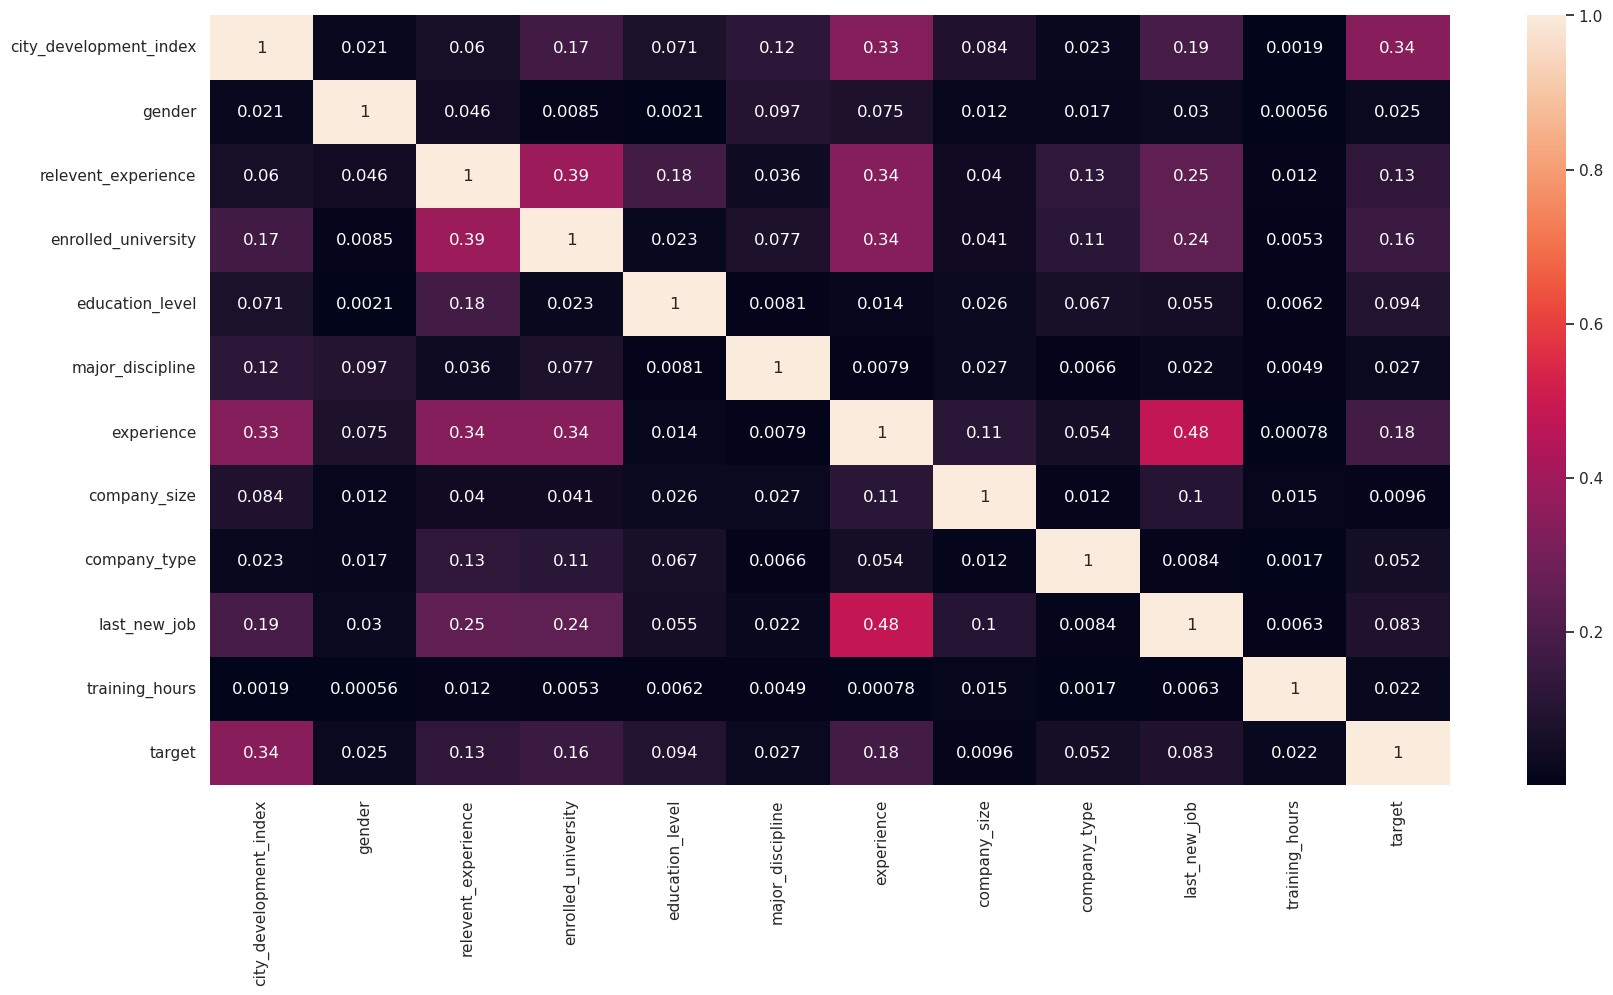

In [25]:
plt.figure(figsize=(20, 10))
correlation_matrix = df.corr().abs()
sns.heatmap(correlation_matrix, annot=True)

In [26]:
sorted_correlations = correlation_matrix['target'].sort_values(ascending=False)
sorted_correlations

target                    1.000000
city_development_index    0.341665
experience                0.176285
enrolled_university       0.155715
relevent_experience       0.128430
education_level           0.094125
last_new_job              0.082607
company_type              0.051878
major_discipline          0.027328
gender                    0.024844
training_hours            0.021577
company_size              0.009603
Name: target, dtype: float64

In [27]:
from reparo import MICE
imputer = MICE()

y = df['target']
X = df.drop('target', axis=1)

imputed_X = X.copy()
imputer.apply(imputed_X, imputed_X.columns)

df = pd.concat([imputed_X, y], axis=1)
df.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,0.920,0.227819,0.214690,0.211406,0.27979,0.261593,21.0,3.452265,0.179448,1.0,36,1.0
1,0.776,0.227819,0.338427,0.211406,0.27979,0.261593,15.0,2.000000,0.180809,5.0,47,0.0
2,0.624,0.231147,0.338427,0.380889,0.27979,0.261593,5.0,2.926058,0.190893,0.0,83,0.0
3,0.789,0.232549,0.338427,0.308730,0.27979,0.262997,0.5,3.063284,0.180809,0.0,52,1.0
4,0.767,0.227819,0.214690,0.211406,0.21440,0.261593,21.0,2.000000,0.139860,4.0,8,0.0


<Axes: >

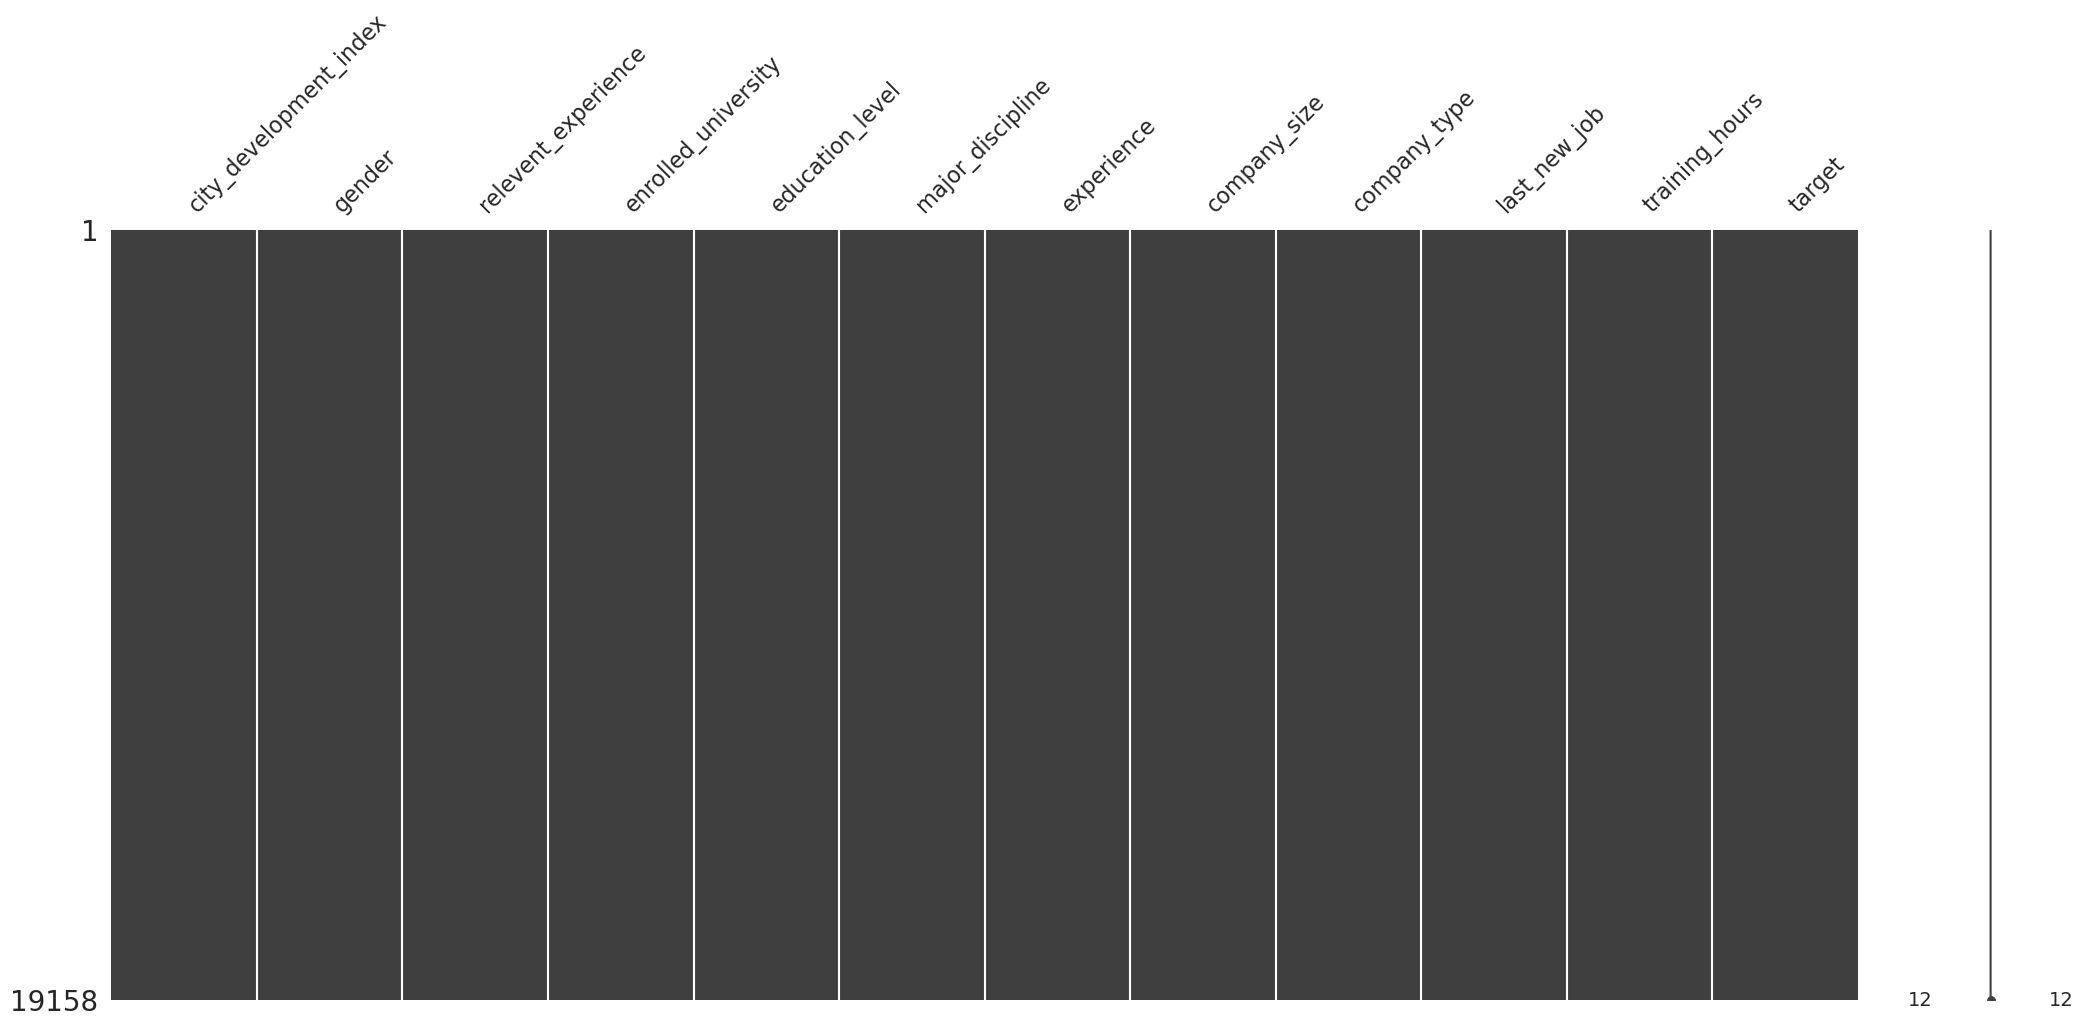

In [28]:
msno.matrix(df)

In [29]:
sorted_correlations = correlation_matrix['target'].sort_values(ascending=False)
sorted_correlations

target                    1.000000
city_development_index    0.341665
experience                0.176285
enrolled_university       0.155715
relevent_experience       0.128430
education_level           0.094125
last_new_job              0.082607
company_type              0.051878
major_discipline          0.027328
gender                    0.024844
training_hours            0.021577
company_size              0.009603
Name: target, dtype: float64

## Data Transformation

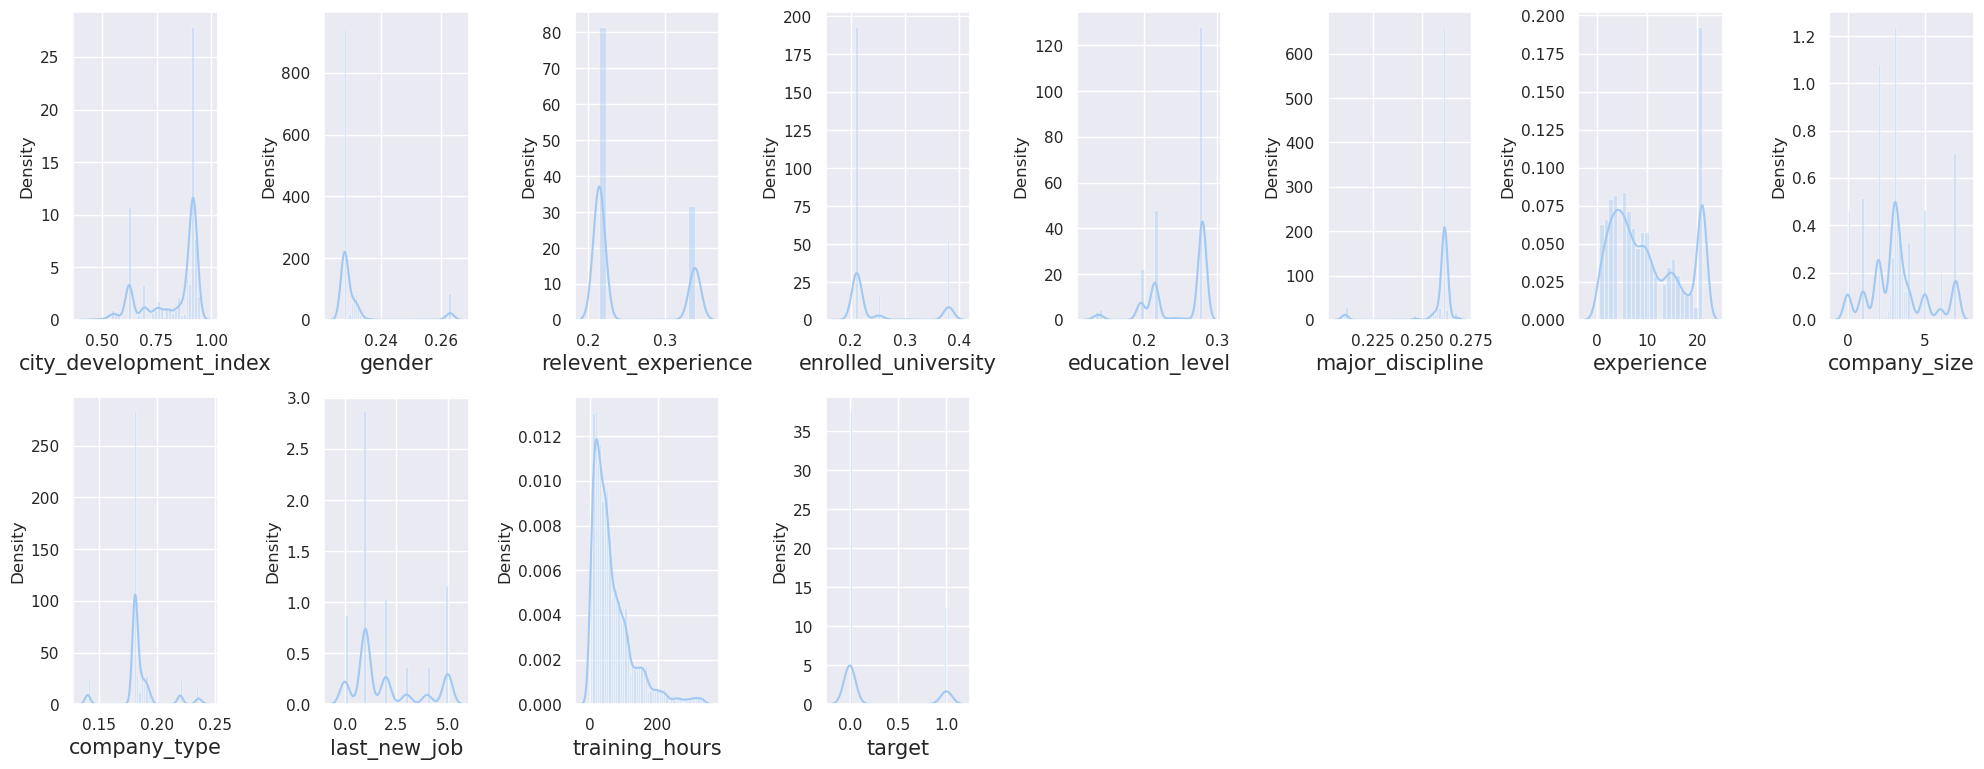

In [30]:
plt.figure(figsize = (20, 15))
plotnumber = 1

for column in df:
    if plotnumber <= 32:
        ax = plt.subplot(4, 8, plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column, fontsize = 15)
        
    plotnumber += 1
    
plt.tight_layout()
plt.show()

In [31]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import f1_score

categorical_columns = ['gender', 
                       'relevent_experience',
                       'enrolled_university',
                       'education_level',
                       'major_discipline',
                       'company_type',
                       'last_new_job',
                       'target']

scalers = {
    "MinMaxScaler": MinMaxScaler(),
    "StandardScaler": StandardScaler()
}

y = df['target']
X = df.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for scaler_name, scaler in scalers.items():
    X_train_scaled, X_test_scaled = X_train.copy(), X_test.copy()
    
    numerical_columns = [col for col in X_train.columns if col not in categorical_columns]
    X_train_scaled[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
    X_test_scaled[numerical_columns] = scaler.transform(X_test[numerical_columns])
    
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train_scaled, y_train)
    
    y_pred = rf_model.predict(X_test_scaled)
    
    f_score = f1_score(y_test, y_pred)
    
    print(f"F-score using {scaler_name}: {f_score}")

F-score using MinMaxScaler: 0.4822609741431149
F-score using StandardScaler: 0.49550089982003603


Since both scalers give practically the same results, we will use MinMaxScaler since it will help us deal with small issues like outliers.  

In [32]:
scaler = MinMaxScaler()
numerical_columns = [col for col in df.columns if col not in categorical_columns]
scaled_data = scaler.fit_transform(df[numerical_columns])
df[numerical_columns] = scaled_data

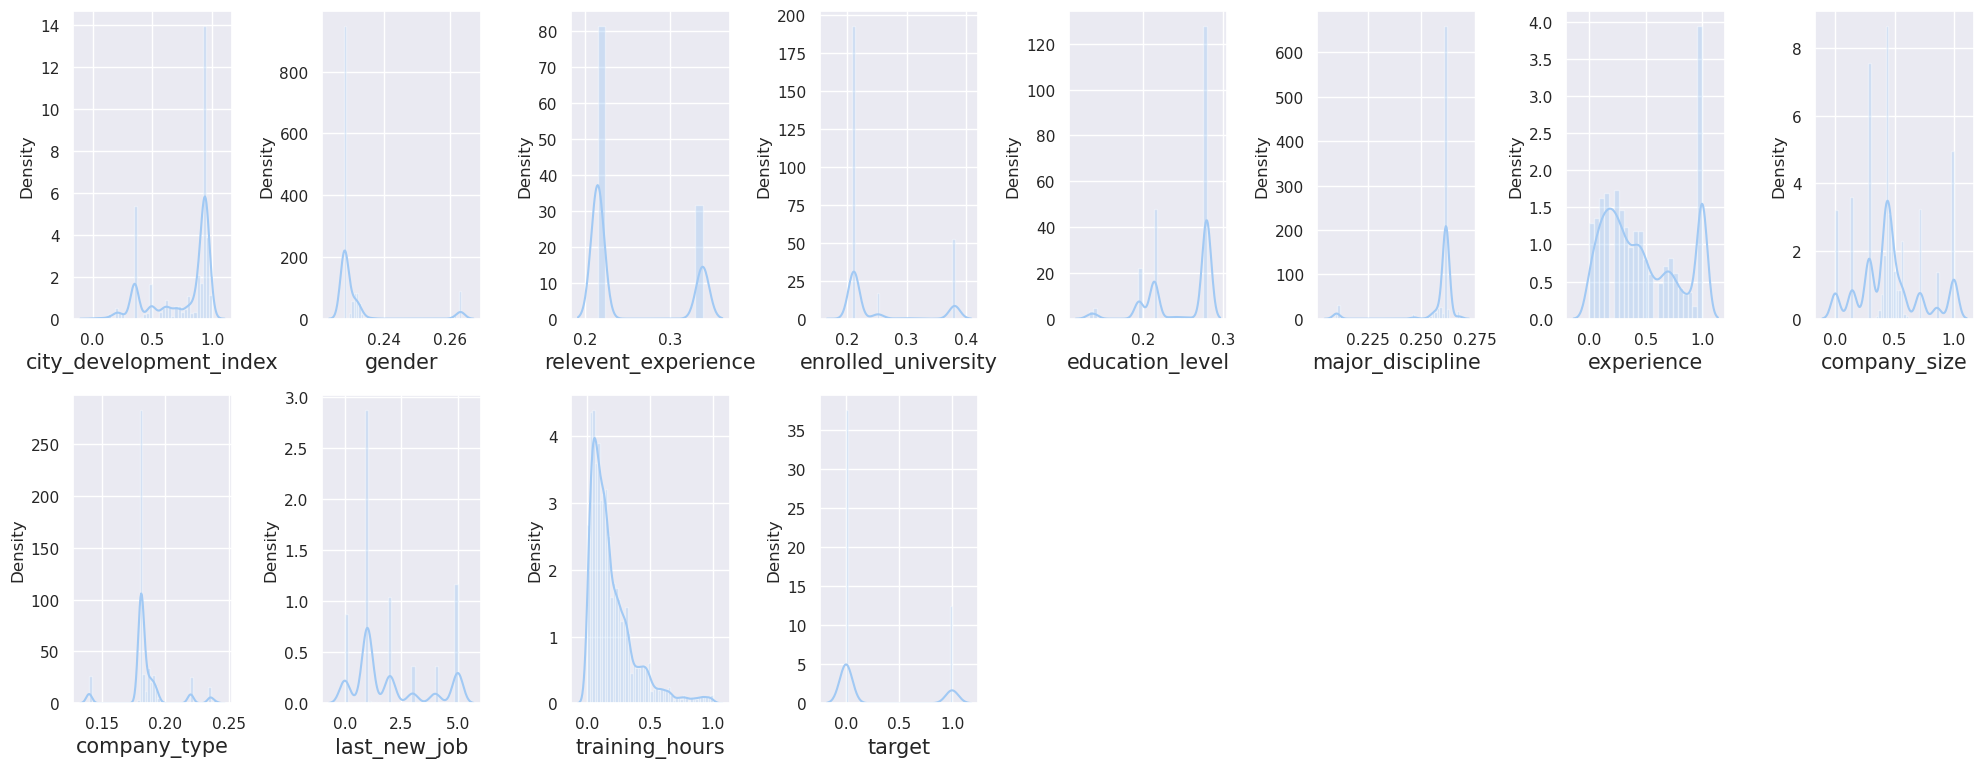

In [33]:
plt.figure(figsize = (20, 15))
plotnumber = 1

for column in df:
    if plotnumber <= 32:
        ax = plt.subplot(4, 8, plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column, fontsize = 15)
        
    plotnumber += 1
    
plt.tight_layout()
plt.show()

As seen, all numerical data, now is shrunk between 0 and 1.

# Feature Selection

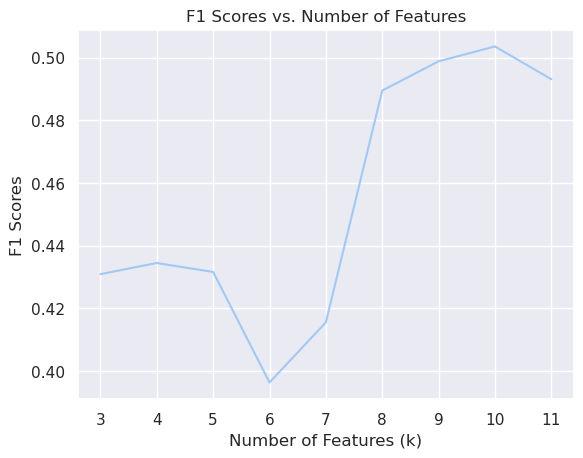

In [34]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

X = df.drop('target', axis=1)
y = df['target']

classifier = RandomForestClassifier()

def calculate_f1(X, y, classifier):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    f1_scores = []
    k_values = range(3, len(X.columns) + 1)

    for k in k_values:
        selected_features = SelectKBest(score_func = chi2, k=k).fit(X_train, y_train)
        X_train_selected = selected_features.transform(X_train)
        X_test_selected = selected_features.transform(X_test)
        classifier.fit(X_train_selected, y_train)

        y_pred = classifier.predict(X_test_selected)
        f1 = f1_score(y_test, y_pred)

        f1_scores.append(f1)
    return k_values, f1_scores

k_values, f1_scores = calculate_f1(X, y, classifier)
plt.plot(k_values, f1_scores)
plt.xlabel('Number of Features (k)')
plt.ylabel('F1 Scores')
plt.title('F1 Scores vs. Number of Features')
plt.show()

After using SelectKBest, the best number of features if the maximum one, thus using the parameter 'all' for k, would be the best choice.

# Class Balancing

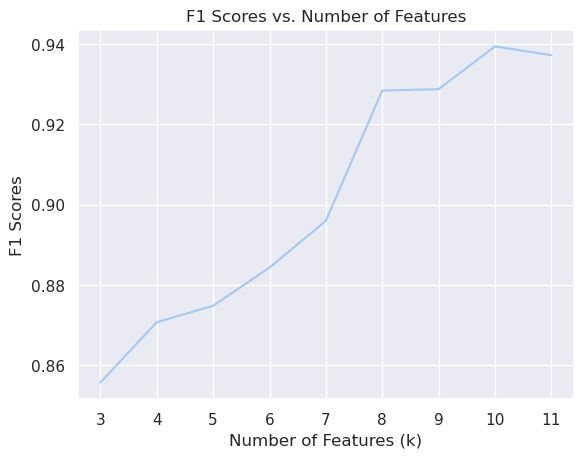

In [35]:
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

resample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
X_res, y_res=resample.fit_resample(X,y)

k_values, f1_scores = calculate_f1(X_res, y_res, classifier)
plt.plot(k_values, f1_scores)
plt.xlabel('Number of Features (k)')
plt.ylabel('F1 Scores')
plt.title('F1 Scores vs. Number of Features')
plt.show()

# Model Selection

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

models = {
    "XGB Classifier": XGBClassifier(),
    "SVM": SVC(),
    "KNN Classifier": KNeighborsClassifier(),
    "Random Forest Classifier": RandomForestClassifier()
}

model_comparison_table, best_model = create_classification_table(models, X_res, y_res)
model_comparison_table

,Estimator,Accuracy,Precision,Recall,F1-Score,Best Model
0,XGB Classifier,0.916838,0.919050,0.916838,0.917444,False
1,SVM,0.755097,0.759257,0.755097,0.756814,False
2,KNN Classifier,0.921879,0.921478,0.921879,0.921516,False
3,Random Forest Classifier,0.918671,0.920443,0.918671,0.919186,True


Now we can conclude that the best model is the Random Forest Classifier due to it's stability and scores.

# Hyperparameter Tuning

Text(0.5, 1.0, 'ROC Curves - Random Forest Classifier')

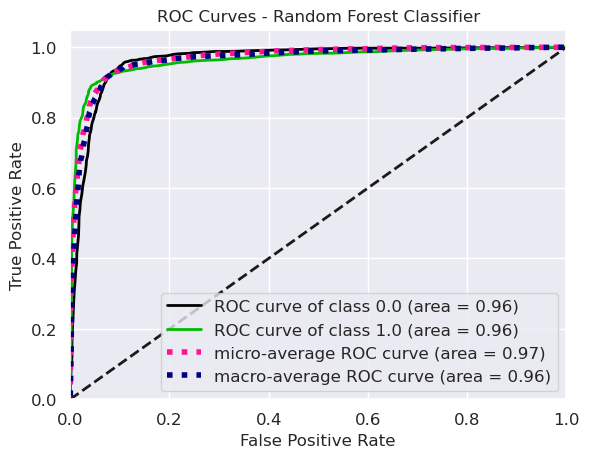

In [47]:
import scikitplot as skplt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier()

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

cl_model = rf_classifier.fit(X_train,y_train)
y_pred = cl_model.predict(X_test)
y_pred_proba = cl_model.predict_proba(X_test)


plot = skplt.metrics.plot_roc(y_test, y_pred_proba)
plt.title("ROC Curves - Random Forest Classifier")

Before starting with Hyperparameter Tuning, I wanted to see how the model behaves. That's why I plotted the results via ROC Curves.
[See link here about ROC Curves](https://stats.stackexchange.com/questions/263121/why-are-the-roc-curves-not-smooth)

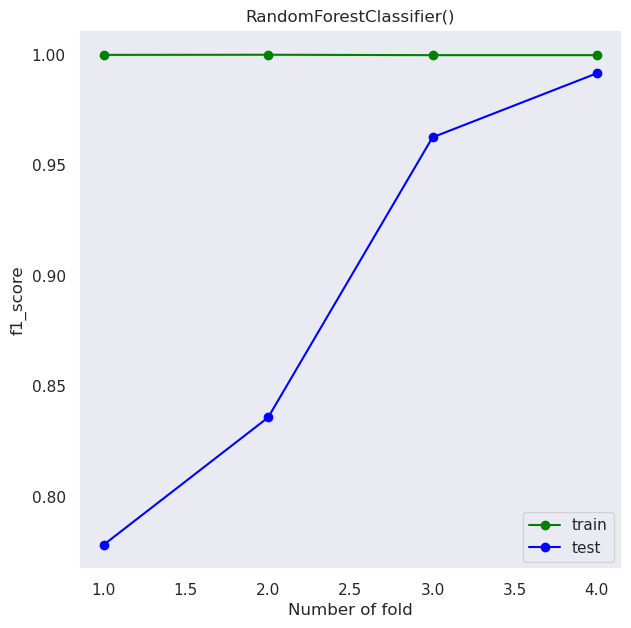

In [48]:
test_train_plot(rf_classifier, X_res, y_res)

The difference between test and train points in the last fold is very small, so the we can conclude that the model is not overfitted and continue our work.

In [62]:
from sklearn.model_selection import RandomizedSearchCV

import random
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_features': [0.4, 0.5, 0.6, 0.7, 0.8],
}

from sklearn.model_selection import cross_val_score

def objective(model, hyperparameters, iteration):
    """Objective function to evaluate the model with cross-validation"""

    model.set_params(**hyperparameters)
    
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

#     scores = cross_val_score(model, X_train, y_train, cv=5) 
    
#     mean_score = scores.mean()
    model.fit(X_train, y_train)
    mean_score = model.score(X_test, y_test)
    
    return {'score': mean_score, 'params': hyperparameters, 'iteration': iteration}


def random_search(model, param_grid, max_evals=20):
    """Random search for hyperparameter optimization"""
    
    results = pd.DataFrame(columns=['score', 'params', 'iteration'])
    print('Loading evals: ')
    for i in range(max_evals):
        
        print(i)
        
        hyperparameters = {param: random.choice(values) for param, values in param_grid.items()}
        
        model.set_params(**hyperparameters)
        
        eval_results = objective(model, hyperparameters, i)
        
        results.loc[i, ['score', 'params', 'iteration']] = eval_results['score'], hyperparameters, i
    
    results.sort_values('score', ascending=False, inplace=True)
    results.reset_index(drop=True, inplace=True)
    
    return results

random_search(rf_classifier, param_grid)

Loading evals: 
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


,score,params,iteration
0,0.915699,"{'n_estimators': 200, 'criterion': 'entropy', ...",8
1,0.914325,"{'n_estimators': 100, 'criterion': 'entropy', ...",14
2,0.91402,"{'n_estimators': 100, 'criterion': 'entropy', ...",0
3,0.913867,"{'n_estimators': 50, 'criterion': 'entropy', '...",5
4,0.913561,"{'n_estimators': 300, 'criterion': 'entropy', ...",7
5,0.913256,"{'n_estimators': 300, 'criterion': 'entropy', ...",16
6,0.913256,"{'n_estimators': 100, 'criterion': 'entropy', ...",2
7,0.913103,"{'n_estimators': 100, 'criterion': 'entropy', ...",18
8,0.913103,"{'n_estimators': 300, 'criterion': 'gini', 'ma...",1
9,0.912951,"{'n_estimators': 300, 'criterion': 'gini', 'ma...",4
